In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# print(os.walk('/0Dataset'))
for dirname, _, filenames in os.walk('C:/Users/Rohan/OneDrive/Desktop/""Sem_5/ANN/Mini-Project/drums_mid'):
    print(dirname,filenames)
    for filename in filenames:
        print("hello")
        print(os.path.join(dirname, filename))
# for (root,dirs,files) in os.walk('/0Dataset',topdown=True):
    print

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#Installing dependencies
# !pip install music21
# !apt-get install -y lilypond
!python.exe -m pip install python-ly

# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">LSTM'S ALBUM RELEASE</p>

<img src="https://github.com/KarnikaKapoor/Files/blob/main/music1.gif?raw=true">

<p style="font-family:newtimeroman;font-size:120%;color:#97BACB;">In one of my previous notebooks, I created an RNN that generates lyrics. For such projects, we feed the network a series of strings and the network predicts the next string in the series based on the information it is trained on. This time I decided to use the same principle on the music. 
Full disclosure I am not a musician. However, I know a tiny bit of music theory and play the ukulele for fun. Nonetheless, If you are a musical novice, don't shy away dive right into this notebook. </p> 

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
 <p style="font-family:newtimeroman;color:#97BACB#97BACB;font-size:120%;text-align:center;border-radius:40px 40px;">TABLE OF CONTENTS</p>   
    
* [1. IMPORTING LIBRARIES](#1)
    
* [2. LOADING DATA](#2)
    
* [3. DATA EXPLORATION](#3)  
    
* [4. DATA PREPREPROCESSING](#4)  
    
* [5. MODEL BUILDING](#5) 
      
* [6. EVALUATING MODELS](#6)
    
* [7. CONCLUSION](#7)
    
* [8. END](#8)


<a id="1"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">IMPORTING LIBRARIES</p>


In [3]:
# !pip install pandas
# !pip install -U scikit-learn
# !pip install seaborn
# !pip install music21

In [4]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import mean_squared_error
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax, RMSprop
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

<a id="2"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">LOADING DATA</p>

For this project, I will be using MIDI files of classical piano music. The dataset includes various artists. I will be working with Frédéric Chopin's compositions. 
 
* First of all, I make a list of all the songs in the Chopin folder parsed as music21 stream.

* Then I will be creating a function to extract chords and notes out of the data creating a corpus.

**Loading and parsing data**

In [5]:
#Loading the list of chopin's midi files as stream 
filepath = "C:/Users/Rohan/OneDrive/Desktop/Sem_5/ANN/Mini-Project/0Dataset/mozart/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [6]:
# !pip install python-ly
all_midis

[<music21.stream.Score 0x1fe16038700>,
 <music21.stream.Score 0x1fe25acf700>,
 <music21.stream.Score 0x1fe258b08e0>,
 <music21.stream.Score 0x1fe24e6a1f0>,
 <music21.stream.Score 0x1fe2ccb0b20>,
 <music21.stream.Score 0x1fe2d12acd0>,
 <music21.stream.Score 0x1fe2fc8eb50>,
 <music21.stream.Score 0x1fe33a16df0>,
 <music21.stream.Score 0x1fe2e1229a0>,
 <music21.stream.Score 0x1fe35c44b50>,
 <music21.stream.Score 0x1fe3719b070>,
 <music21.stream.Score 0x1fe35f11f10>,
 <music21.stream.Score 0x1fe3c8c0490>,
 <music21.stream.Score 0x1fe3f70a190>,
 <music21.stream.Score 0x1fe40c9fc40>,
 <music21.stream.Score 0x1fe41fde670>,
 <music21.stream.Score 0x1fe442ddfd0>,
 <music21.stream.Score 0x1fe44914d60>,
 <music21.stream.Score 0x1fe44ae5550>,
 <music21.stream.Score 0x1fe48b49d60>,
 <music21.stream.Score 0x1fe48afd820>]

Next, I get the components out of these streams of MIDI files. The midi files only have the piano included as mentioned in the dataset. So the components of the file would be either piano chords or piano notes. 

**Note:** The musical notes are the building blocks of the music. It pertains to a pitch associated with a specific audio vibration. Western music utilizes twelve musical notes. 

**Chord:** A group of notes that sound good together is a chord.

The music21 stream that was created in the above cell contains both, chords and notes, we will extract them in the form of notes and obtain a series of notes in the musical composition.

**The function to get the notes:**

In [22]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 55802


So we have our data in the form of a corpus. A list of strings, if you will. Each string indicates a musical note. Let us explore this data corpus.

<a id="3"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">DATA EXPLORATION</p>

**In this section, I will be:**
* Exploring the data Corpus
* Examine all the notes in the Corpus 
* Simplifying our Corpus to Built a working model

**Let us have a look at the first 50 values in our corpus**

In [104]:
print("First fifty values in the Corpus:", Corpus[:100])

First fifty values in the Corpus: ['2.6.9', '9.2', 'G5', '2.6', 'F#5', 'E5', 'F#5', 'A5', '4.7', 'G5', 'F#5', 'G5', 'A5', '6.9', 'A5', 'B5', 'C#6', 'D6', 'A5', 'F#3', 'D4', 'F#5', 'D3', 'D4', 'A5', 'E3', 'G5', 'F#5', 'D4', 'G5', 'A5', 'A3', 'G5', 'C#4', 'F5', '2', 'F#5', 'G5', '2.6', 'F#5', 'E5', 'F#5', 'A5', '4.7', 'G5', 'F#5', 'G5', 'A5', '6.9', 'A5', 'B5', 'C#6', 'D6', 'A5', 'F#3', 'D4', 'F#5', 'D3', 'D4', 'A5', 'E3', 'G5', 'F#5', 'D4', 'G5', 'A5', 'A3', 'G5', 'F#5', 'C#4', 'E5', 'D5', 'D4', 'F#4', 'A4', 'D4', 'F#4', '6.7', 'D4', '6.7', 'F#4', '6.7', '6.7', 'D4', 'F#5', 'E5', 'F#4', 'D5', 'C#5', 'E4', 'G4', 'A4', 'E4', 'G4', 'E5', 'E4', 'F#4', 'G4', 'F#4', 'E4']


All these values indicate the notes, as mentioned above.

**Printing the music sheet**

In [24]:
us = environment.UserSettings()
# us.create()
us['lilypondPath'] = 'C:/Program Files (x86)/LilyPond/usr/bin/lilypond.exe'

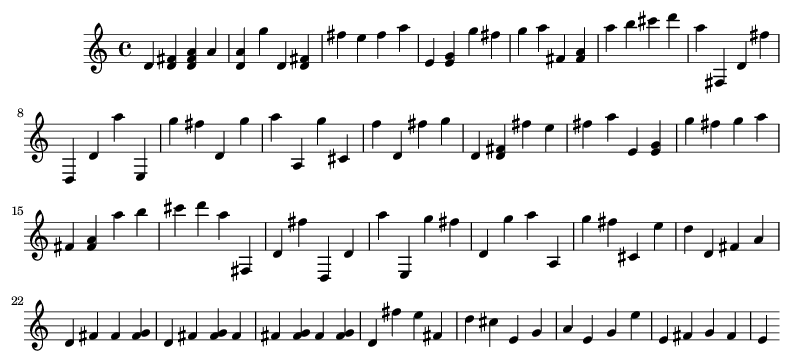

In [25]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

**Playing the above sheet music** 

*As I could not play a midi file on the Kaggle interface, I have created a ".wav" filetype of the same outside of this code. I am using it to create an audio interface. Let us have a listen to the data corpus.* 

In [26]:
#to play audio or corpus
print("Sample Audio From Data")
# IPython.display.Audio("../input/music-generated-lstm/Corpus_Snippet.wav") 

Sample Audio From Data


**Examine all the notes in the Corpus** 

In [27]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 229


In [28]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 243.6768558951965
Most frequent note in Corpus appeared: 2355 times
Least frequent note in Corpus appeared: 1 time


Clearly, there are some very rare notes in the melody; some so rare that it was played only once in the whole data. This would create a lot of problems. (I did run into most of them while writing this piece)
To spare us the error reports, let us have a look at the frequency of the notes. 
And for simplicity, I shall be eliminating some of the least occurring notes. I am sure Chopin wouldn't mind me messing with his masterpiece for science or would he? Either way, I may never know!   

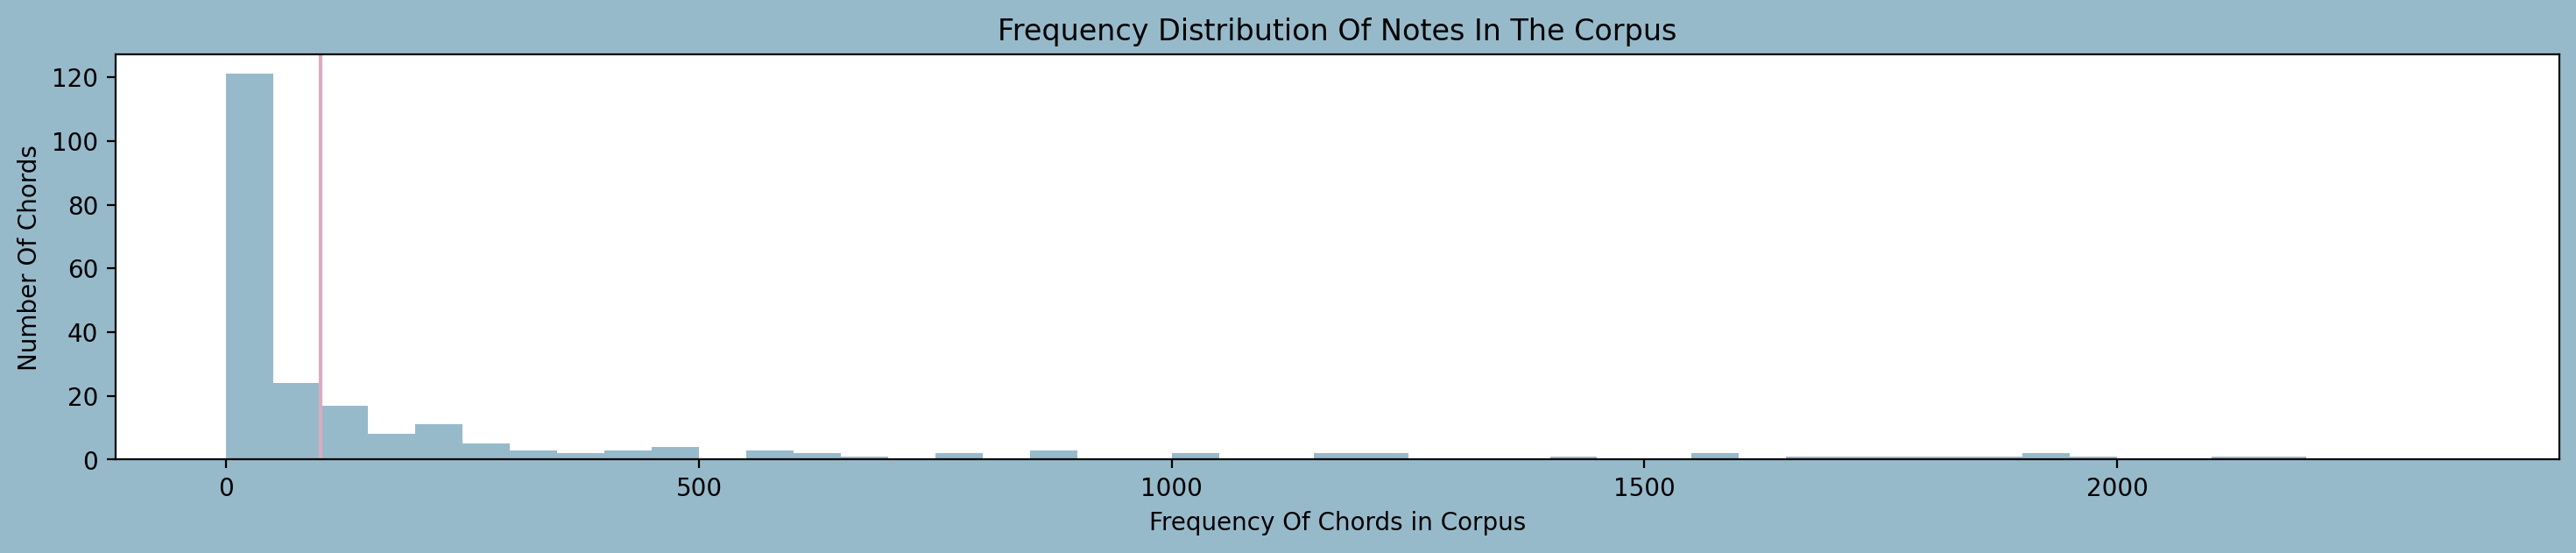

In [29]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

I have decided, I will be taking out the notes that were played less than 100 times. I mean, if Chopin liked them he would have played it a lot more often. So I create a list of rare notes in the next section. 

In [30]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 145


In [31]:
# #Eleminating the rare notes
# for element in Corpus:
#     if element in rare_note:
#         Corpus.remove(element)

# print("Length of Corpus after elemination the rare notes:", len(Corpus))

Finally! This is the cleaned data Corpus that I will be using for the music generation.  
In the next section, I will be preprocessing this Corpus for the training model. 

The workflow for this project involves,

<p style="background-color:#EBDDD0;font-family:newtimeroman;color:#444160;text-align:center;font-size:120%;">Loading Data ➡️ Preprocessing ➡️ Building Mapping Dictionary ➡️ Building Model ➡️ Generating Music</p>

As I have loaded and explored the data,  I will proceed further by pre-processing the text.  


<a id="4"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">DATA PREPROCESSING</p>

Notes are basically sound waves. In music, we have certain specific combinations of Frequency and Wavelength standardized as said notes. Our Corpus has the name of that note. As we parsed the data at the time of loading we took the help of the music21 library (by nice people at MIT); The library fetches Frequency, Wavelength, duration etc for the given notes. 



**In this section, I will be performing the following:**

**Creating a dictionary:** Creating a dictionary to map the notes and their indices. We have the note's name as a string the Corpus. For the computer, these names are just a symbol. So we create a dictionary to map each unique note in our Corpus to a number. And vice versa to retrieve the values at the time of prediction. This will be used to encode and decode the information going in and getting out of the RNN. 

**Encoding and Splitting the corpus:** Encoding and splitting the corpus into smaller sequences of equal length: At this point, the Corpus contain notes. We will encode this corpus and create small sequences of equal lengths of features and the corresponding targets. Each feature and target will contain the mapped index in the dictionary of the unique characters they signify. 

**Assigning X and y:** The labels are then resized and normalized. Whereas the targets are one-hot encoded. Ready to be sent to the RNN for the training, but before that let us built the RNN model. 

**Splitting Train and Seed datasets** To create music we will need to send some input to the RNN. For that, we will set aside a part of the data as seeds. We could have trained it all but I am no musician to come up with an input seed value. 

**Creating a list of sorted unique characters**

In [32]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 55802
Number of unique characters: 229


**Encoding and Splitting the Corpus as Labels and Targets**

In [33]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 55762


In [34]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

**Splitting Train and Seed datasets**

In [35]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

<a id="5"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">MODEL BUILDING</p>

I will be employing an LSTM for this project.

**Following steps are involved in the model building**

* Initialising the Model
* Defining by adding layers
* Compiling the Model
* Training the Model

**Building the Model**

In [36]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
# opt = Adamax(learning_rate=0.01)
opt = RMSprop()
# model.compile(loss='categorical_crossentropy', optimizer=opt)
model.compile(loss=mean_squared_error, optimizer=opt)


In [37]:
#Model's Summary               
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 512)           1052672   
_________________________________________________________________
dropout (Dropout)            (None, 40, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 229)               58853     
Total params: 1,964,773
Trainable params: 1,964,773
Non-trainable params: 0
______________________________________________

In [38]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

Epoch 1/200
175/175 [==============================] - 16s 51ms/step - loss: 0.0043
Epoch 2/200
175/175 [==============================] - 9s 51ms/step - loss: 0.0043
Epoch 3/200
175/175 [==============================] - 9s 51ms/step - loss: 0.0043
Epoch 4/200
175/175 [==============================] - 11s 63ms/step - loss: 0.0043
Epoch 5/200
175/175 [==============================] - 10s 55ms/step - loss: 0.0043
Epoch 6/200
175/175 [==============================] - 13s 77ms/step - loss: 0.0043
Epoch 7/200
175/175 [==============================] - 12s 67ms/step - loss: 0.0043
Epoch 8/200
175/175 [==============================] - 9s 52ms/step - loss: 0.0043
Epoch 9/200
175/175 [==============================] - 9s 52ms/step - loss: 0.0043
Epoch 10/200
175/175 [==============================] - 9s 52ms/step - loss: 0.0043
Epoch 11/200
175/175 [==============================] - 9s 52ms/step - loss: 0.0043
Epoch 12/200
175/175 [==============================] - 9s 52ms/step - loss: 0.0

<a id="6"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">EVALUATING MODELS</p>

Now that I have my model trained on the MIDI files of piano music, let us see how it performs. 

**To evaluate my model, I shall be having a look at:**
* The performance of the model via Learning Curves
* The melody created

**Plotting the learning curve for the loss function**

[Text(0.5, 0, 'Epochs')]

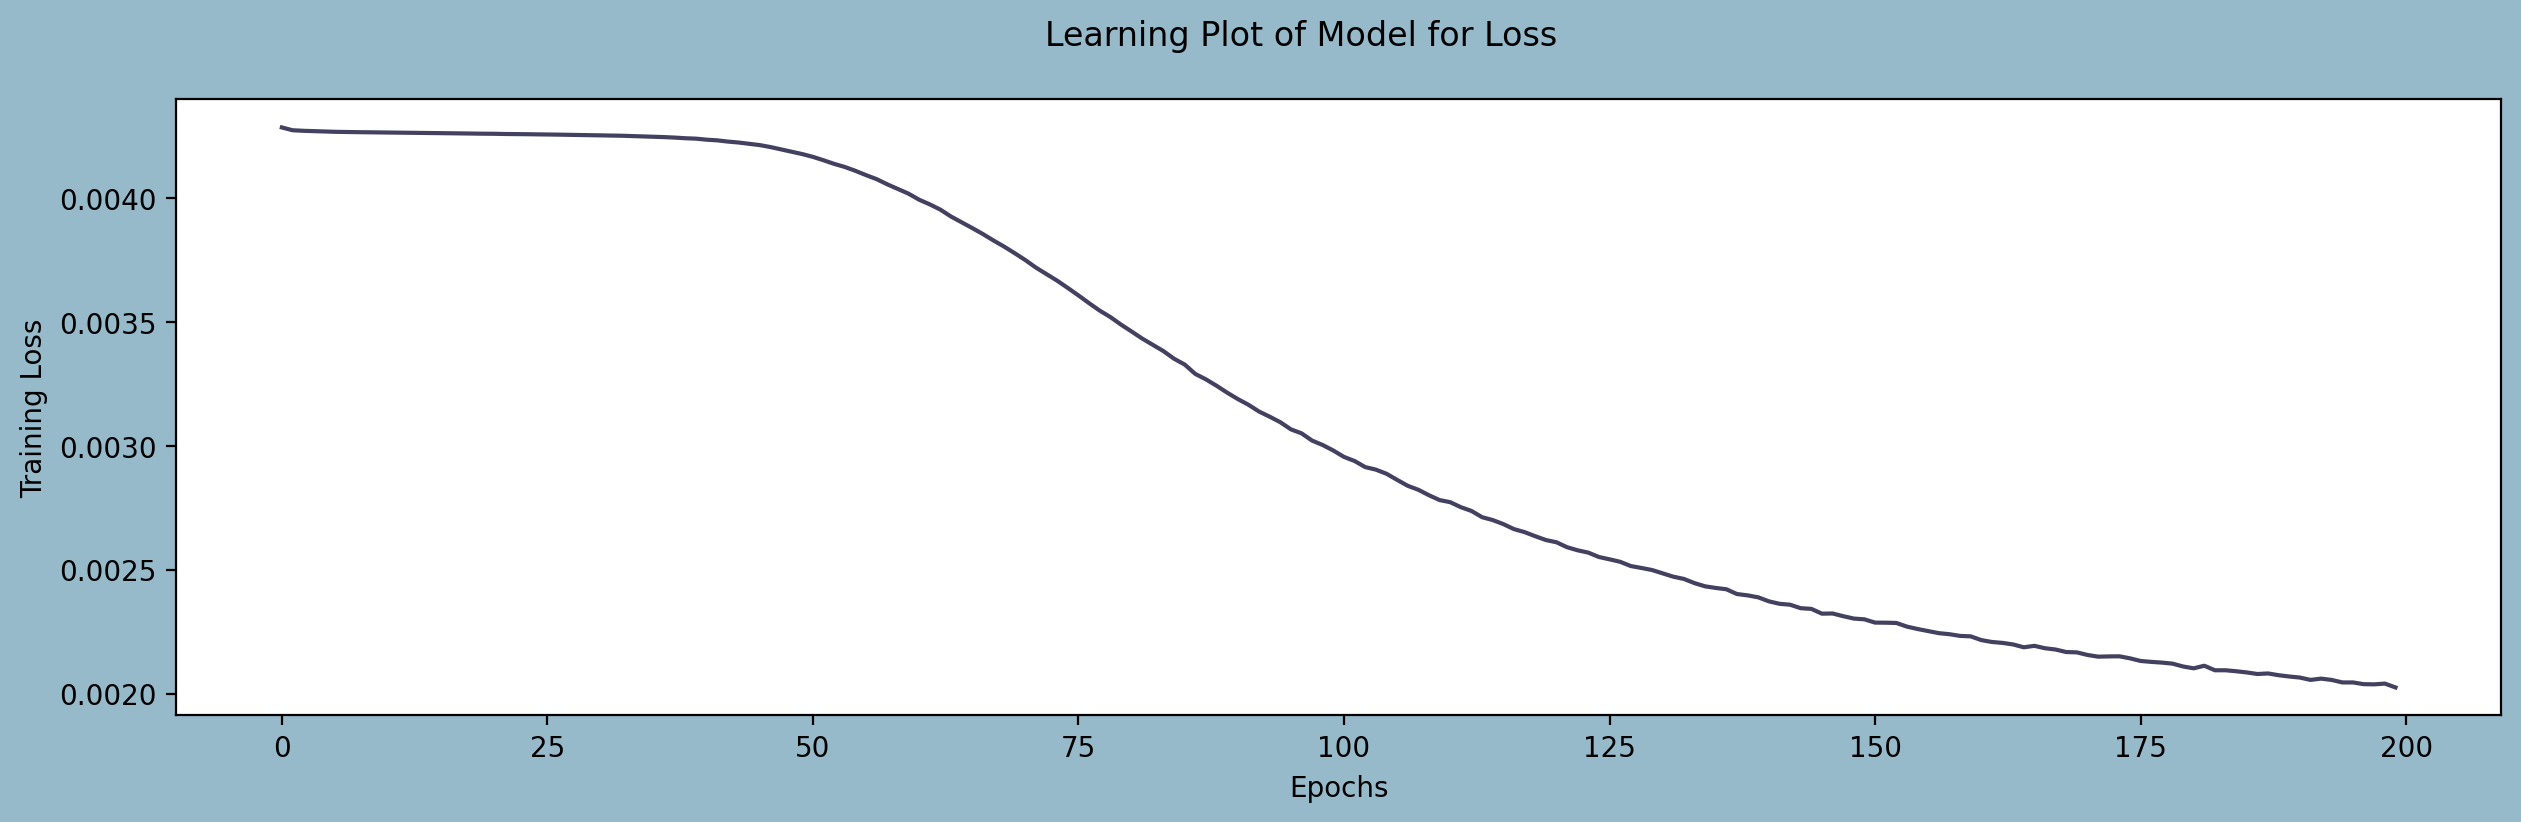

In [39]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [40]:
history.history

{'loss': [0.004286011215299368,
  0.004274727776646614,
  0.004272493999451399,
  0.004271030891686678,
  0.004269274417310953,
  0.00426838081330061,
  0.004267592914402485,
  0.0042670550756156445,
  0.00426658196374774,
  0.004266276024281979,
  0.0042657507583498955,
  0.004265255760401487,
  0.004264597315341234,
  0.004263821057975292,
  0.004263624083250761,
  0.004262976348400116,
  0.004262418486177921,
  0.0042617893777787685,
  0.004261501599103212,
  0.004260719753801823,
  0.004260411486029625,
  0.004259560722857714,
  0.004259352106601,
  0.004258738365024328,
  0.004258253611624241,
  0.004257436376065016,
  0.004256968852132559,
  0.0042562843300402164,
  0.004255590494722128,
  0.004254845902323723,
  0.0042540542781353,
  0.0042534200474619865,
  0.004252536687999964,
  0.004251220729202032,
  0.004250089637935162,
  0.004248279146850109,
  0.004247012082487345,
  0.004244995303452015,
  0.004242407623678446,
  0.00424074474722147,
  0.004236532375216484,
  0.0042338

In [41]:
# acc_df = pd.DataFrame(history.history)
# fig2 = plt.figure(figsize=(15,4), facecolor="#97BACB")
# fig.suptitle("Learning Plot of Model for Accuracy")
# pl=sns.lineplot(data=acc_df["accuracy"],color="#0000FF")
# pl.set(ylabel = "Training Accuracy")
# pl.set(xlabel = "Epochs")

**Generating the Melody**

A function to obtain the generated music

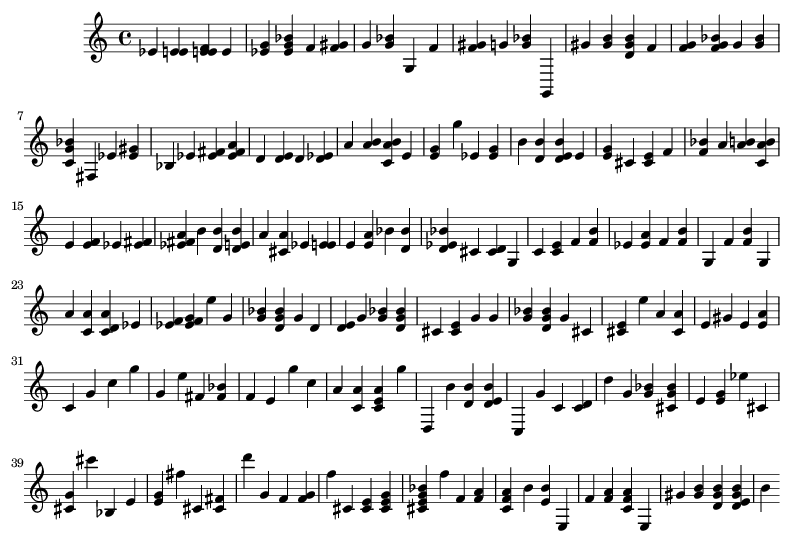

In [42]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)
show(Melody)

This sure looks like music! To check if it sounds like music we have to listen to the MIDI file. Playing midi is crumblesome. I have saved and converted a few generated melodies to ".wav" format outside of this notebook. So let us have a listen. 

**Melody Generated Sample 1**

In [45]:
#To save the generated melody
Melody.write('midi','Melody_Generated8.mid')
#to play audio or corpus
# IPython.display.Audio("../input/music-generated-lstm/Melody_Generated 2.wav")

'Melody_Generated8.mid'

**Melody Generated Sample 2**

In [46]:
#to play audio or corpus
IPython.display.Audio("../input/music-generated-lstm/Melody_Generated_1.wav")

ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [47]:
midi_gen = converter.parse('C:/Users/Rohan/OneDrive/Desktop/Sem_5/ANN/Mini-Project/Melody_Generated8.mid')
Corpus_Gen = extract_notes([midi_gen])
print("Total notes in all the Chopin midis in the dataset:", len(Corpus_Gen))

Total notes in all the Chopin midis in the dataset: 100


In [48]:
# Corpus_Gen
def unique_checker(all_midis, midi_gen):
    

In [49]:
# Corpus

In [114]:
def sequence_accuracy(main, gen, num):
    count = int(0)
    check = int(0)
    d1 = {}
    isunique = True
    for i in range(len(gen)-num):
        for j in range(len(main) - num):
            if gen[i:i+num] == main[j:j+num]:
                check+=1
                if str(gen[i:i+num]) not in d1:
                    d1[str(gen[i:i+num])] = 1
                else:
                    d1[str(gen[i:i+num])] += 11
            count += 1
    print(f"Same Value: {check}")
    print(f"Total Value: {count}")
    print(d1)
    print(sum(d1.values()))
    return d1

In [119]:
d1 = sequence_accuracy(Corpus, Corpus_Gen, 2)
print(len(Corpus))

Same Value: 931
Total Value: 5468400
{"['5.8', '7.10']": 78, "['7.10', 'G3']": 56, "['G3', '5.8']": 45, "['4.7', 'G5']": 243, "['G5', '3.7']": 67, "['4.7', '1.4']": 12, "['1.2', 'G3']": 12, "['G3', '0.4']": 133, "['5.11', 'G3']": 78, "['G3', '5.11']": 12, "['E5', '7.10.2']": 1, "['7.10.2', 'G4']": 56, "['G4', '2.4']": 45, "['1.4', 'G4']": 67, "['G4', '1.4']": 12, "['1.4', 'E5']": 221, "['E5', '9.1']": 309, "['9.1', 'E4']": 518, "['E4', 'G#4']": 188, "['G#4', '4.9']": 12, "['C4', 'G4']": 1618, "['G4', 'C5']": 1013, "['C5', 'G5']": 364, "['G5', 'G4']": 595, "['G4', 'E5']": 1046, "['E5', '6.10']": 12, "['F4', 'E4']": 859, "['E4', 'G5']": 606, "['G5', 'C5']": 298, "['G5', 'D3']": 320, "['C3', 'G4']": 56, "['G4', '0.2']": 243, "['0.2', 'D5']": 1, "['4.7', 'E-5']": 12, "['C#6', 'B-3']": 1, "['B-3', '4.7']": 45, "['4.7', 'F#5']": 45, "['D6', 'G4']": 111, "['G4', '5.7']": 166, "['5.7', 'F5']": 100, "['F5', '1.4.7.10']": 12, "['F5', '5.9.0']": 67, "['E3', '8.11.2.4']": 56}
9811
55802


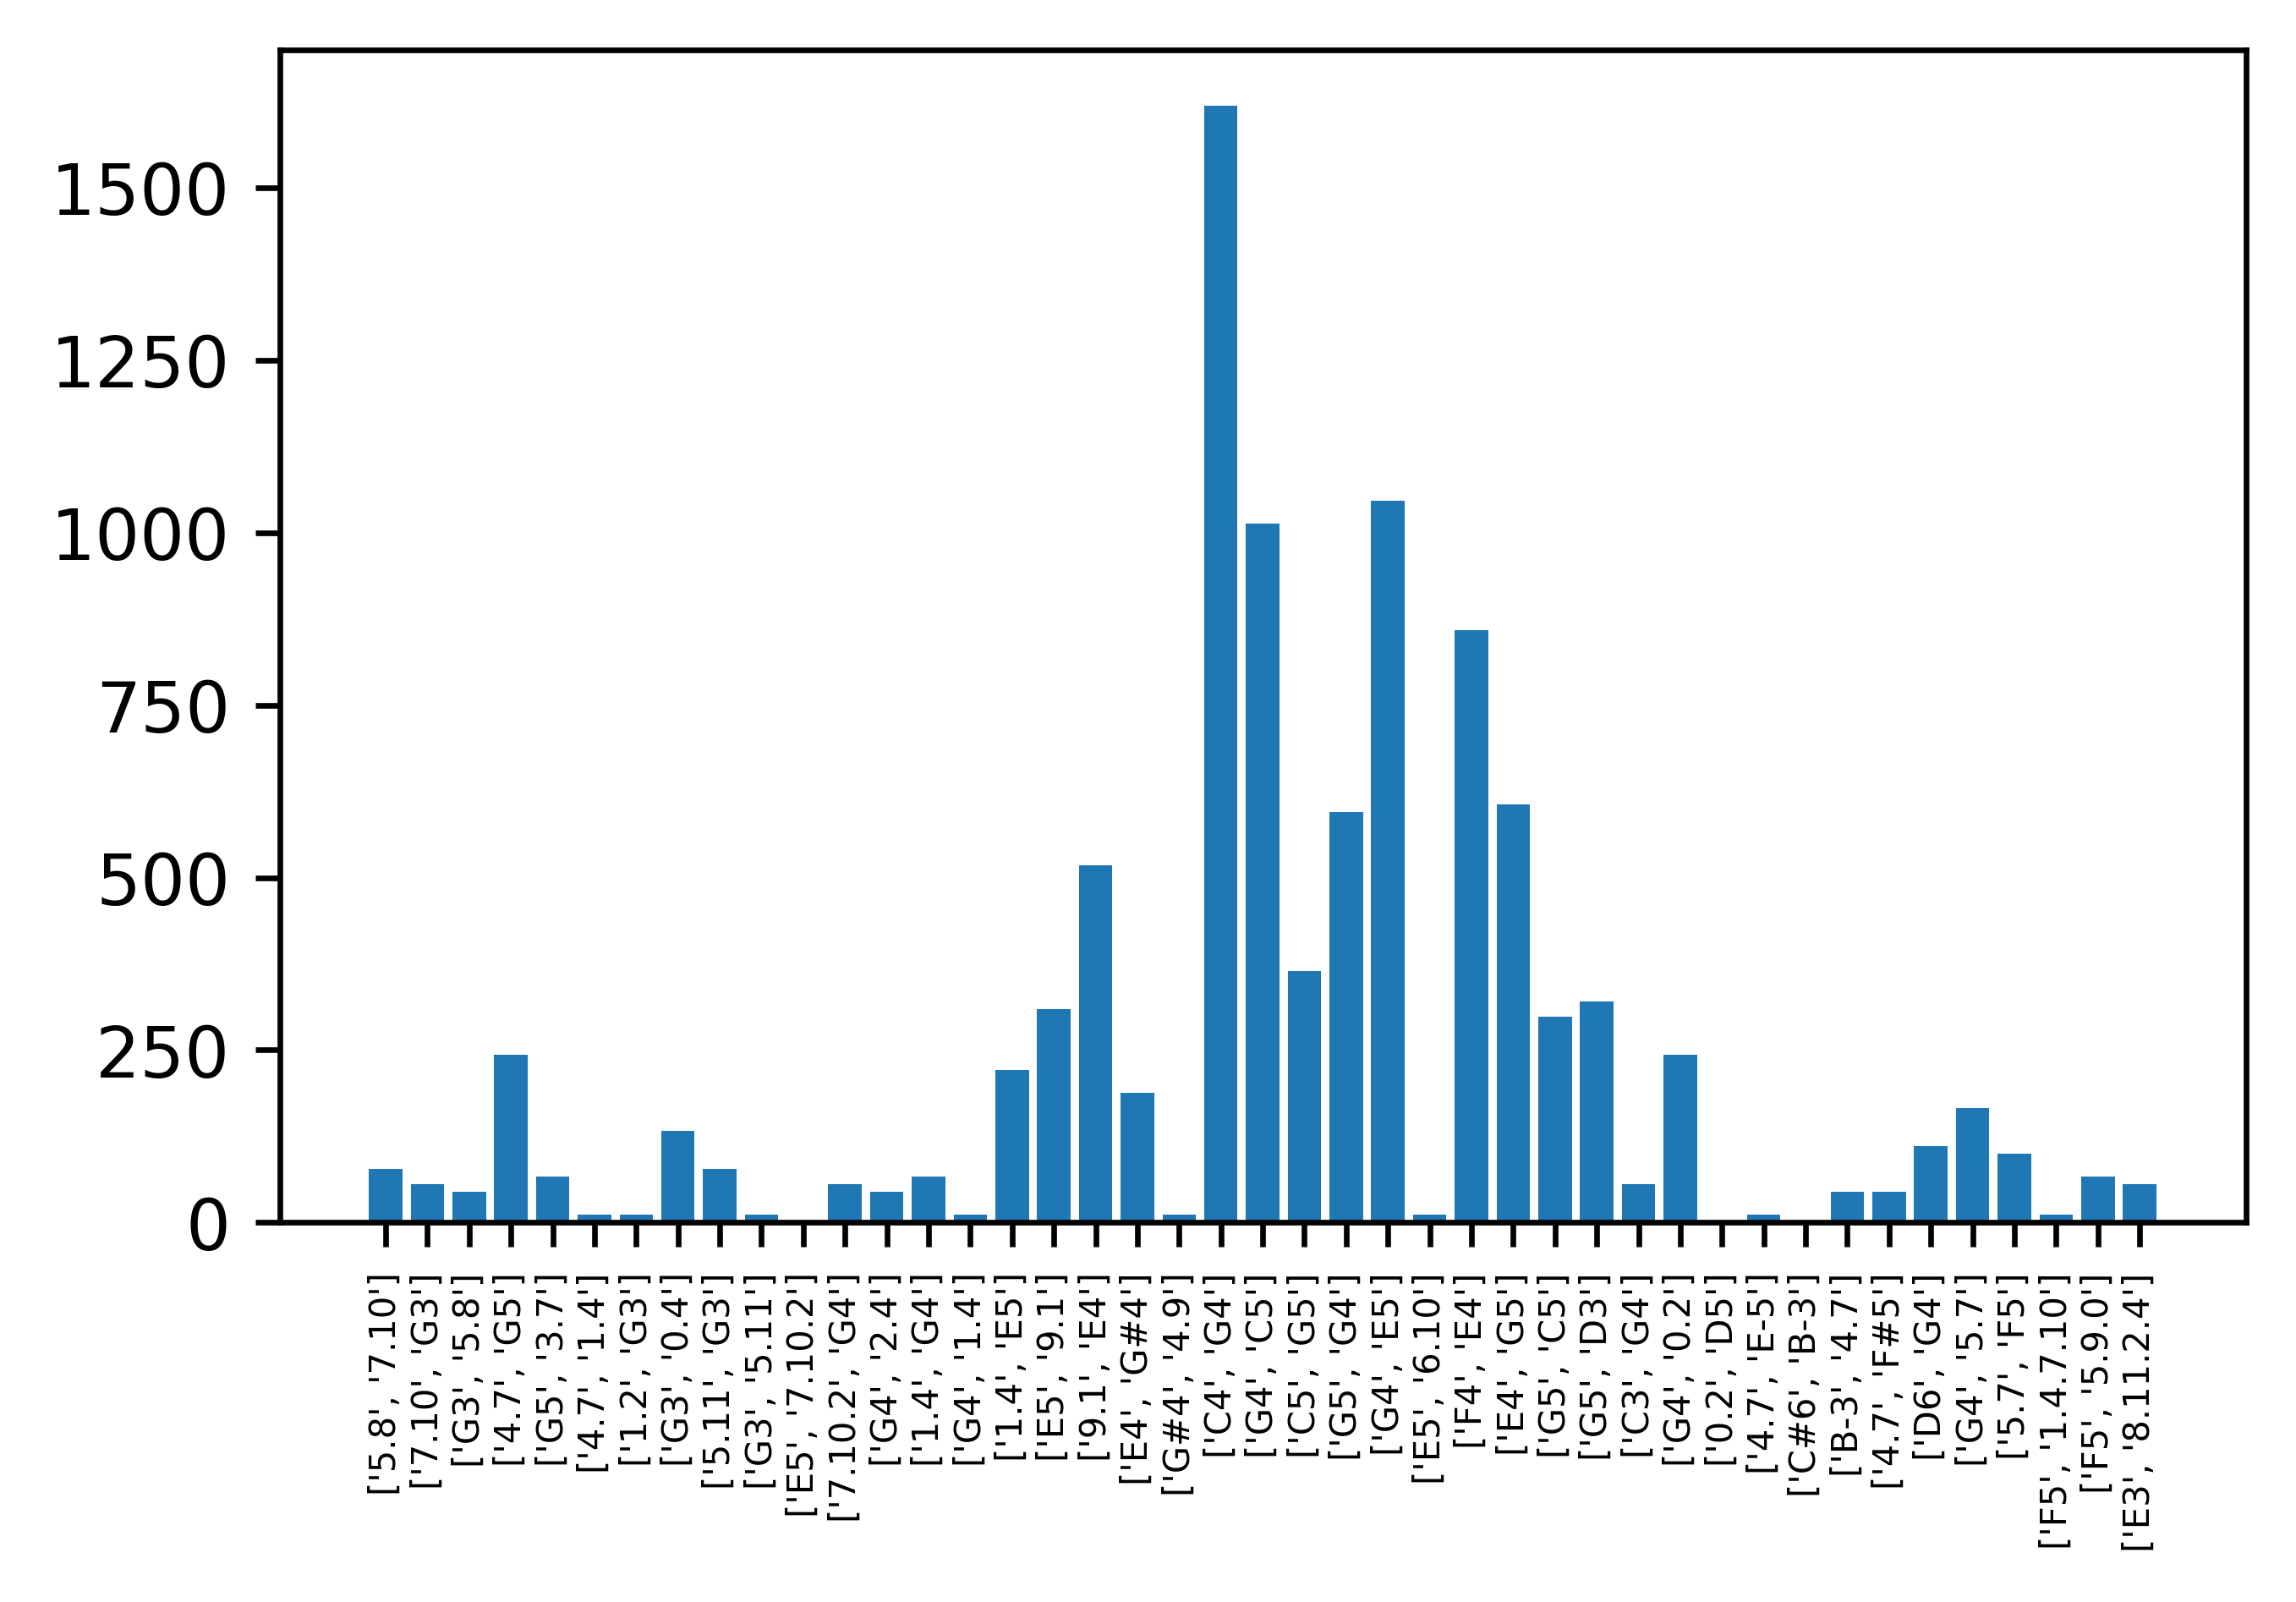

In [127]:
fig = plt.figure(figsize=(5,3),dpi=300)
plt.bar(range(len(d1.values())), list(d1.values()), align='center')
plt.xticks(range(len(d1)), list(d1.keys()), rotation='vertical',fontsize=5)
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.show()